# Option Pricing & Validation, and 1d VaR

### Author: AK

### Date: 4 Sept 2014

Description:
------------
This Python script contains functions to calculate option prices using spot prices.
The calculations are based on the methodology provided in an Excel model. The script
also includes validation checks and lastly, calculates 1d VaR

Functions:
----------
- black_scholes(spot_price, strike_price, trade_date, expiry_date, volatility, risk_free_rate, option_type):
    Computes the option price using the Black-Scholes formula.

- price_option():
    Validates the option pricing model and replicates the pricing using QuantLib.

- calculate_VaR():
    Computes the 1-day Value at Risk based on the provided methodology.

Validation Checks:
------------------
1. Sensitivity of option prices to spot price changes.
2. Delta behavior analysis.
3. Replication and comparison of option prices using QuantLib.


Dependencies:
-------------


In [ ]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
from scipy.stats import norm
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import QuantLib as ql

## Option Pricing Function Using Spot Prices

The Python function below is designed to calculate the option price using spot prices. The function is based on the same methodology and inputs as provided in the Excel model.

---

In [ ]:
def black_scholes(S, K, trade_date, expiry_date, r, sigma, option_type='call'):
    """
    Calculate the Black-Scholes option price using spot prices as inputs.

    """
    # Calculate T (time to expiration in years)
    T = (expiry_date - trade_date).days / 365
    # Calculate r_cont
    r_cont = math.log(1+r)
    # Calculate d1 and d2 parameters
    d1 = (math.log(S / K) + (r_cont + 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)

    # Calculate call or put option price
    if option_type == 'call':
        option_price = S * norm.cdf(d1) - K * math.exp(-r_cont * T) * norm.cdf(d2)
    elif option_type == 'put':
        option_price = K * math.exp(-r_cont * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

    return option_price

# Calculating option price
S = 19     # Stock price
K = 17     # Strike price
trade_date = datetime(2022, 11, 23)  # Trade date
expiry_date = datetime(2023, 5, 10) # Expiry date
r = 0.005    # Risk-free interest rate (0.5%)
sigma = 0.3 # Volatility of the underlying (30%)

call_price = black_scholes(S, K, trade_date, expiry_date, r, sigma, option_type='call')
put_price = black_scholes(S, K, trade_date, expiry_date, r, sigma, option_type='put')

print(f"Call Option Price: {call_price:.2f}")
print(f"Put Option Price: {put_price:.2f}")

Call Option Price: 2.70
Put Option Price: 0.66


## Validation of the Option Pricing Model

The option pricing model has been validated through several checks, including scenarios where the option is **ITM**, **ATM**, and **OTM**. Additionally, the model's results were replicated using QuantLib.

### 1. Spot Price Variation and Impact on Option Pricing and Delta

#### 1a. Option Price Sensitivity to Spot Price Changes
**Check:** Varied the spot price to observe how the call and put option prices change, focusing on how the prices behave when the option is ITM, ATM, and OTM.

**Outcome:**
- **OTM Options:** As expected, the price of OTM options tends toward zero but retains a small value due to the time value of the option.
- **ATM Options:** When the option is ATM, the price reflects the time value.
- **ITM Options:** The price of ITM options increases with the degree of moneyness.

**Result:** The option prices change in line with expectations, confirming that the model is behaving correctly.  
**Status:** Pass

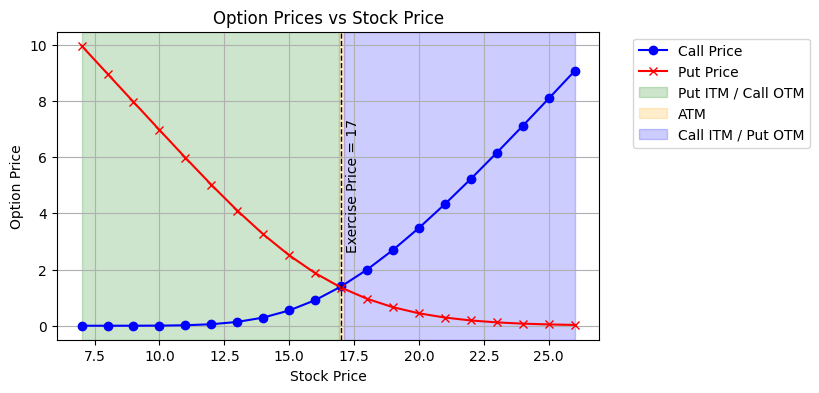

In [ ]:
# Vary Spot prices, S, from K-10 to K+10
S_values = np.arange(K-10, K+10, 1)
call_prices = []
put_prices = []

for S1 in S_values:
    call_price = black_scholes(S1, K, trade_date, expiry_date, r, sigma, option_type='call')
    put_price = black_scholes(S1, K, trade_date, expiry_date, r, sigma, option_type='put')
    call_prices.append(call_price)
    put_prices.append(put_price)

# Create DataFrame
df = pd.DataFrame({'Stock Price': S_values, 'Call Price': call_prices, 'Put Price': put_prices})

# Plotting
plt.figure(figsize=(7, 4))
plt.plot(df['Stock Price'], df['Call Price'], label='Call Price', marker='o', color='blue')
plt.plot(df['Stock Price'], df['Put Price'], label='Put Price', marker='x', color='red')

# Shading regions
plt.axvspan(K-10, K-.1, alpha=0.2, color='green', label='Put ITM / Call OTM')  # ITM for puts, OTM for calls
plt.axvspan(K-.1,K+.1, alpha=0.2, color='orange', label='ATM')                # ATM region (narrow range around exercise price)
plt.axvspan(K+.1, K+9, alpha=0.2, color='blue', label='Call ITM / Put OTM')               # ITM for calls, OTM for puts

# Vertical line at the exercise price
plt.axvline(x=K, color='black', linestyle='--', linewidth=1)
plt.text(K + 0.2, 5, 'Exercise Price = 17', rotation=90, verticalalignment='center', color='black')

# Labels and title
plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.title('Changes in Option Prices behavior by changing Stock Price')
# plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

#### 1b. Delta Behavior with Spot Price Changes
**Check:** The behavior of the delta was analyzed to ensure it aligns with standard expectations.

**Observation:**
- **Call Delta:** Varies between 0 and 1, showing a value of 0.5 when the option is ATM.
- **Put Delta:** Varies between -1 and 0, with a value of -0.5 when the option is ATM.
- **Delta Curve:** The S-shaped curve observed for both call and put options is consistent with standard delta behavior.

**Result:** The delta behavior is as expected, showing the model's accuracy.  
**Status:** Pass



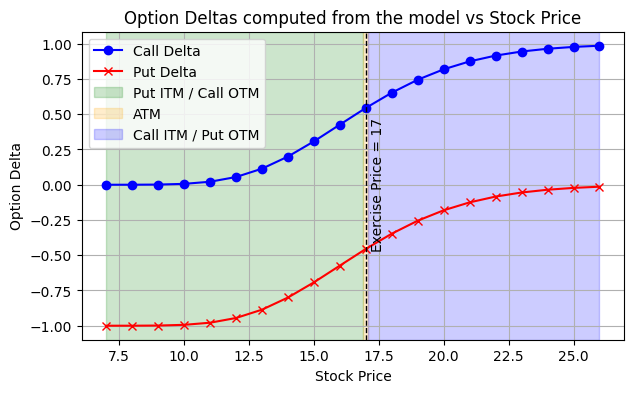

In [ ]:
def calculate_d1(S, K, T, r, sigma):
    """Calculate d1 """
    T = (expiry_date - trade_date).days / 365
    return (math.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T))

def delta_call(S, K, trade_date, expiry_date, r, sigma, option_type='call'):
    """
    Calculate the delta of a European call option using the Black-Scholes model.
    """
    # Calculate time to expiration in years
    T = (expiry_date - trade_date).days / 365

    # Calculate d1 using the helper function
    d1 = calculate_d1(S, K, T, r, sigma)

    # Calculate delta
    if option_type == 'call':
        delta = norm.cdf(d1)
    elif option_type == 'put':
        delta = norm.cdf(d1) - 1

    return delta

call_deltas = []
put_deltas = []
r_cont = math.log(1+r)
for S1 in S_values:
    call_delta = delta_call(S1, K, trade_date, expiry_date, r_cont, sigma, 'call')
    put_delta = delta_call(S1, K, trade_date, expiry_date, r, sigma, 'put')
    call_deltas.append(call_delta)
    put_deltas.append(put_delta)

df2 = pd.DataFrame({'Stock Price': S_values, 'Call Delta': call_deltas, 'Put Delta': put_deltas})
# Plotting
plt.figure(figsize=(7, 4))
plt.plot(df2['Stock Price'], df2['Call Delta'], label='Call Delta', marker='o', color='blue')
plt.plot(df2['Stock Price'], df2['Put Delta'], label='Put Delta', marker='x', color='red')

# Shading regions
plt.axvspan(K-10, K-.1, alpha=0.2, color='green', label='Put ITM / Call OTM')  # ITM for puts, OTM for calls
plt.axvspan(K-.1,K+.1, alpha=0.2, color='orange', label='ATM')                # ATM region (narrow range around exercise price)
plt.axvspan(K+.1, K+9, alpha=0.2, color='blue', label='Call ITM / Put OTM')               # ITM for calls, OTM for puts
plt.axvline(x=K, color='black', linestyle='--', linewidth=1)
plt.text(K + 0.2, 0, 'Exercise Price = 17', rotation=90, verticalalignment='center', color='black')

# Labels and title
plt.xlabel('Stock Price')
plt.ylabel('Option Delta')
plt.title('Option Deltas computed from the model vs Stock Price')
plt.legend()
plt.grid(True)
plt.show()

### 2. Validation with QuantLib

**Check:** The option pricing results were replicated and validated using the QuantLib library.

**Outcome:** The same option prices were obtained when using QuantLib, confirming the accuracy of the model.

**Result:** Test Pass

---

In [ ]:
def price_option(S, K, trade_date, expiry_date, r, sigma, option_type='call'):
    if option_type == 'call':
        option_type_ql = ql.Option.Call
    else:
        option_type_ql = ql.Option.Put

    trade_date_ql = ql.Date(trade_date.day, trade_date.month, trade_date.year)
    expiry_date_ql = ql.Date(expiry_date.day, expiry_date.month, expiry_date.year)

    payoff = ql.PlainVanillaPayoff(option_type_ql, K)
    exercise = ql.EuropeanExercise(expiry_date_ql)

    european_option = ql.VanillaOption(payoff, exercise)

    dividend_yield = 0.0  # no dividends

    calendar = ql.UnitedStates(ql.UnitedStates.NYSE)  # Assumed calendar
    day_count = ql.Actual365Fixed()
    ql.Settings.instance().evaluationDate = trade_date_ql
    spot_handle = ql.QuoteHandle(ql.SimpleQuote(S))

    risk_free_rate_handle = ql.YieldTermStructureHandle(
        ql.FlatForward(trade_date_ql, r, day_count))

    volatility_handle = ql.BlackVolTermStructureHandle(
        ql.BlackConstantVol(trade_date_ql, calendar, sigma, day_count))

    dividend_yield_handle = ql.YieldTermStructureHandle(
        ql.FlatForward(trade_date_ql, dividend_yield, day_count))

    bsm_process = ql.BlackScholesMertonProcess(spot_handle, dividend_yield_handle,
                                               risk_free_rate_handle, volatility_handle)

    engine = ql.AnalyticEuropeanEngine(bsm_process)
    european_option.setPricingEngine(engine)
    option_price = european_option.NPV()
    return option_price


In [ ]:
call_price = price_option(S, K, trade_date, expiry_date, r, sigma, option_type='call')
put_price = price_option(S, K, trade_date, expiry_date, r, sigma, option_type='put')

print(f"Call Option Price from Quantlib: {call_price:.2f}")
print(f"Put Option Price from Quantlib: {put_price:.2f}")

Call Option Price from Quantlib: 2.70
Put Option Price from Quantlib: 0.66


## 1d Value at Risk (VaR) Calculation

The 1-day VaR is calculated below based on the methodology provided in the Excel model.

In [ ]:
# Read the Excel file
df = pd.read_excel('TRM Engineering_Interview_Option_VaR_.xlsx', sheet_name='VaR Calculation', skiprows=5)
df = df[['date', 'Portfolio', df.columns[df.columns.get_loc('Portfolio') + 1], df.columns[df.columns.get_loc('Portfolio') + 2]]]
df.columns = ['date', 'Portfolio', 'market_rate_ccy1', 'market_rate_ccy2']
df.head()

,date,Portfolio,market_rate_ccy1,market_rate_ccy2
0,2019-11-14,FXTEST,1.168443,0.886564
1,2019-11-13,FXTEST,1.165977,0.884330
2,2019-11-12,FXTEST,1.166031,0.883470
3,2019-11-11,FXTEST,1.166902,0.877539
4,2019-11-08,FXTEST,1.160726,0.877659


In [ ]:
def calculate_VaR(df, spot_portfolio_value_ccy1, spot_portfolio_value_ccy2):
    # Calculate 1-day shifts
    df['1d_shift_ccy1'] = np.exp(np.log(df['market_rate_ccy1'] / df['market_rate_ccy1'].shift(-1))) - 1
    df['1d_shift_ccy2'] = np.exp(np.log(df['market_rate_ccy2'] / df['market_rate_ccy2'].shift(-1))) - 1

    # Calculate PnL vectors
    df['pnl_vector_ccy1'] = spot_portfolio_value_ccy1 * df['1d_shift_ccy1']
    df['pnl_vector_ccy2'] = spot_portfolio_value_ccy2 * df['1d_shift_ccy2']

    # Calculate Total PnL
    df['Total_PnL'] = df['pnl_vector_ccy1'] + df['pnl_vector_ccy2']

    # Calculate VaR
    second_smallest = df['Total_PnL'].nsmallest(2).iloc[-1]
    third_smallest = df['Total_PnL'].nsmallest(3).iloc[-1]
    VaR_1d = 0.4 * second_smallest + 0.6 * third_smallest

    return VaR_1d

spot_portfolio_value_ccy1 = 153084.81
spot_portfolio_value_ccy2 = 95891.51
VaR_1d = calculate_VaR(df, spot_portfolio_value_ccy1, spot_portfolio_value_ccy2)
print(f"One day VaR : {VaR_1d:.4f}")

One day VaR : -13572.7338
